### VAE implementation for domain transfer

In [7]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
import torch
import numpy as np
import scanpy as sc
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split



import torch.nn as nn

def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class encoder(nn.Module):
    def __init__(self, x_dim, hid_dim=64, z_dim=64, 
                 p_drop=0):
        super(encoder, self).__init__()
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded  
    
class decoder(nn.Module):
    def __init__(self, y_dim, hid_dim=64, z_dim=64, 
                 p_drop=0):
        super(decoder, self).__init__()
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, y_dim, p_drop),
        )
        
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded  
    
class VAE(pl.LightningModule):
    def __init__(self, input_dim=50, y_dim=512, 
                 enc_out_dim=512, latent_dim=256):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = encoder(input_dim, latent_dim, enc_out_dim)
        self.decoder = decoder(y_dim, enc_out_dim, latent_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum()
        #return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, y)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = vae.transform(batch[0])
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, y)
        
        return recon_loss
    
    def transform(self, x):
        """
        Performs multi modal domain alignment after training
        """
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
    
        # decoded 
        x_hat = vae.decoder(z)
        return x_hat
        
class multimodal(Dataset):
    def __init__(self, gex1, atac):
        
        self.gex1 = torch.Tensor(gex1.X.toarray())
        self.atac = torch.Tensor(atac.X.toarray())

    def __len__(self):
        return self.gex1.shape[0]

    def __getitem__(self, idx):
        return self.gex1[idx], self.atac[idx]
    


### Read in data and create dataloader

In [91]:
print("Setting up dataloaders")

# Gene Expression Dataset 1 (GEX1)
gex1 = sc.read_h5ad('../multiome/multiome_gex_processed_training.h5ad')

# DNA Accessibility Dataset (ATAC)
atac = sc.read_h5ad('../multiome/multiome_atac_processed_training.h5ad')

idx = np.arange(len(gex1))
trainval, test_idx = train_test_split(idx, test_size=0.10, shuffle=True)
train_idx, val_idx = train_test_split(trainval, test_size=0.10, shuffle=True)

gex1_train = gex1[train_idx]
gex1_val = gex1[val_idx]
gex1_test = gex1[test_idx]

atac_train = atac[train_idx]
atac_val = atac[val_idx]
atac_test = atac[test_idx]

train_dl = DataLoader(multimodal(gex1_train, atac_train), batch_size=64, shuffle=False)
val_dl = DataLoader(multimodal(gex1_val, atac_val), batch_size=64, shuffle=False)
test_dl = DataLoader(multimodal(gex1_test, atac_test), batch_size=64, shuffle=False)

### Train model

In [99]:
pl.seed_everything(1234)

vae = VAE(input_dim=gex1.shape[1], y_dim=atac.shape[1])

print("Dataloaders created")

trainer = pl.Trainer(gpus=1, max_epochs=50, progress_bar_refresh_rate=10,
                    default_root_dir='./checkpoints/')

trainer.fit(vae, train_dl, val_dl)

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK:

Epoch 0:  49%|█████████████████████▌                      | 140/285 [03:37<03:45,  1.56s/it, loss=8.12e+06, v_num=0]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 682, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 770, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 1193, in _run
    self._dispatch()
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 1272, in _dispatch
    self.training_type_plugin.start_training(self)
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/plugins/training_type/training_type_plugin.py", line 202, in start_training
    self._results = trainer.run_stage()
  File "/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 1282, in run_stage

TypeError: object of type 'NoneType' has no len()

In [47]:
vae = vae.load_from_checkpoint('../checkpoints/lightning_logs/version_0/checkpoints/epoch=49-step=17549.ckpt')

In [ ]:
preds = []

for it, batch in enumerate(dl):
    print(it)
    out = vae.transform(batch[0])
    preds.extend(out.detach().cpu().numpy())
    
preds = np.stack(preds)

0
1
2
3
4
5
6


In [ ]:
# First convert data matrix into Scanpy Anndata object
pred_adata = sc.AnnData(preds)

# Then add metadata labels for coloring the plot
# First for the model prediction
if len(pred_adata) != len(atac):
    # Subsetting to match the same size as the training set
    pred_adata.obs = atac.obs[:len(pred_adata)]
else:
    pred_adata.obs = atac.obs

# Then for the true value
if len(pred_adata) != len(atac):
    true_adata = atac[:len(pred_adata)]
    true_adata.obs = atac.obs[:len(pred_adata)]
else:
    true_adata = atac

In [ ]:
sc.pp.neighbors(pred_adata)
sc.pp.neighbors(true_adata)

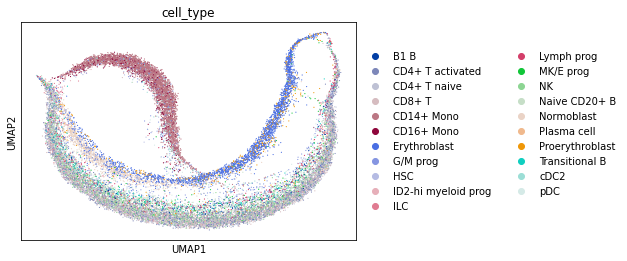

In [74]:
sc.tl.umap(pred_adata)
sc.pl.umap(pred_adata, color=['cell_type'])

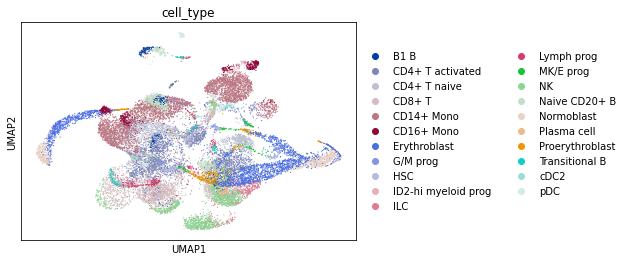

In [75]:
sc.tl.umap(true_adata)
sc.pl.umap(true_adata, color=['cell_type'])

In [4]:
def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    ################################################################################
    # TODO: Modify/complete the code here

    dist = torch.distributions.normal.Normal(m, torch.sqrt(v))
    log_probs = dist.log_prob(x).sum(-1)

    # Compute element-wise log probability of normal and remember to sum over
    # the last dimension
    ################################################################################

    ################################################################################
    # End of code modification
    ################################################################################
    return log_probs

In [5]:
def log_normal2(x , m , v):
    element_wise = -0.5 * ( torch . log (v) + (x - m). pow (2) / v + np . log (2 * np .pi))
    log_prob = element_wise . sum (-1 )
    return log_prob

In [11]:
log_normal(torch.Tensor([5,3,4]),torch.Tensor([1,2,2]),torch.Tensor([4,2,3]))

tensor(-7.2625)

In [12]:
log_normal2(torch.Tensor([5,3,4]),torch.Tensor([1,2,2]),torch.Tensor([4,2,3]))

tensor(-7.2625)

In [29]:
def log_normal_mixture(z, m, v):
    """
    Computes log probability of Gaussian mixture.

    Args:
        z: tensor: (batch, dim): Observations
        m: tensor: (batch, mix, dim): Mixture means
        v: tensor: (batch, mix, dim): Mixture variances

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    ################################################################################
    # TODO: Modify/complete the code here
    # Compute the uniformly-weighted mixture of Gaussians density for each sample
    # in the batch

    dist = torch.distributions.normal.Normal(m, torch.sqrt(v))
    log_probs = dist.log_prob(z.unsqueeze(1))
    log_prob = log_mean_exp(log_probs.sum(-1), 1)

    ################################################################################

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

In [14]:
def log_normal_mixture2(z , m , v):
    # ( batch , dim ) -> ( batch , 1, dim )
    z = z . unsqueeze (1)
    # ( batch , 1 , dim ) -> ( batch , mix , dim ) -> ( batch , mix )
    log_prob = log_normal (z , m , v)
    # ( batch , mix ) -> ( batch ,)
    log_prob = log_mean_exp ( log_prob , dim=1)
    return log_prob

In [18]:
batch = 5
mix = 3
dim = 5

z = torch.rand([batch,dim])
m = torch.rand([batch,mix,dim])
v = torch.rand([batch,mix,dim])

In [30]:
log_normal_mixture(z,m,v)

tensor([-4.5196, -3.2476, -2.3179, -2.0154, -3.9307])

In [22]:
log_normal_mixture2(z,m,v)

tensor([-4.5196, -3.2476, -2.3179, -2.0154, -3.9307])